## HW3: Decision Tree and Random Forest
In hw3, you need to implement decision tree and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [0]:
!pip install sklearn

You should consider upgrading via the 'f:\python\python37\python.exe -m pip install --upgrade pip' command.


## Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

In [41]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
x_train = pd.read_csv("/content/gdrive/My Drive/DecisionTree/x_train.csv")
y_train = pd.read_csv("/content/gdrive/My Drive/DecisionTree/y_train.csv")
x_test = pd.read_csv("/content/gdrive/My Drive/DecisionTree/x_test.csv")
y_test = pd.read_csv("/content/gdrive/My Drive/DecisionTree/y_test.csv")
print(x_train.shape)

(426, 30)


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 7 of hw3 slides](https://docs.google.com/presentation/d/1ish3jEr_6be0FK4kgOZa12nYAyJFh0P2LCNsNPOCiXo/edit#slide=id.g7703d1636d_0_21)

In [0]:
def gini(sequence):
    element1 = np.argmax(np.bincount(sequence))
    size = np.shape(sequence)[0]
    result = 1 - ((list(sequence).count(element1)/size)**2 +
                  ((size-list(sequence).count(element1))/size)**2)
    return result


In [0]:
def entropy(sequence):
    element1 = np.argmax(np.bincount(sequence))
    size = np.shape(sequence)[0]
    count1 = list(sequence).count(element1)
    count2 = size-count1
    if count1 == 0 or count2 == 0:
        return 0
    result = -(count1/size)*np.log2(count1/size) - (count2/size)*np.log2(count2/size)
    return result

In [39]:
# 1 = class 1,
# 2 = class 2
data = np.array([1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2])


[list(data).count(i) for i in set(data)]

[7, 4]

In [19]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [20]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [0]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.importance = []
        self.DT = self.create_tree(x_train, y_train, max_depth)
        self.prediction = self.predict_label(self.DT, x_test)
        self.accuracy = self.evaluation(self.prediction, y_test)
        return None

    def gini(self, sequence):
        element1 = np.argmax(np.bincount(sequence))
        size = np.shape(sequence)[0]
        result = 1 - ((list(sequence).count(element1)/size)**2 +
                  ((size-list(sequence).count(element1))/size)**2)
        return result

    def entropy(self, sequence):
        element1 = np.argmax(np.bincount(sequence))
        size = np.shape(sequence)[0]
        count1 = list(sequence).count(element1)
        count2 = size - count1
        if count1 == 0 or count2 == 0:
            return 0
        result = -(count1 / size) * np.log2(count1 / size) - (count2 / size) * np.log2(count2 / size)
        return result

    def find_threshold(self, x_data, y_data):
        best_criterion = 100
        best_attribute = 'bb'
        best_thershold = 0
        feature = list(x_data.columns)
        for _ in feature:
            column = x_data[_]
            sorted_column = np.sort(column)
            for i in range(column.shape[0] - 1):
                average = (sorted_column[i] + sorted_column[i + 1]) / 2
                left = np.array(y_data[x_data[_] <= average]).reshape(-1,)
                right = np.array(y_data[x_data[_] > average]).reshape(-1,)
                if self.criterion == 'gini':
                    temp_criterion = len(left) / column.shape[0] * self.gini(left) + len(right) / column.shape[0] * self.gini(right)
                else:
                    temp_criterion = len(left) / column.shape[0] * self.entropy(left) + len(right) / column.shape[0] * self.entropy(right)
                if temp_criterion < best_criterion:
                    best_criterion = temp_criterion
                    best_attribute = _
                    best_thershold = average
        left_child = x_data[x_data[best_attribute] <= best_thershold]
        # del left_child[best_attribute]
        left_y = y_data[x_data[best_attribute] <= best_thershold]
        right_child = x_data[x_data[best_attribute] > best_thershold]
        # del right_child[best_attribute]
        right_y = y_data[x_data[best_attribute] > best_thershold]

        return left_child, left_y, right_child, right_y, best_attribute, best_thershold

    def majorityClass(self, dataSet):
        labels = list(dataSet.iloc[:, -1])
        element1 = np.argmax(np.bincount(labels))
        return element1

    # %%
    def create_tree(self, x_data, y_data, max_depth):
        if x_train.shape[1] - len(x_data.columns) > self.max_depth-1:
            return self.majorityClass(y_data)
        if len(set(y_data.iloc[:, -1])) == 1:
            return y_data.iloc[0, -1]
        left_child, left_y, right_child, right_y, bestAttribute, bestTh = self.find_threshold(x_data, y_data)
        decisionTree = {bestAttribute: {}}
        print(decisionTree)
        self.importance.append(bestAttribute)
        decisionTree[bestAttribute][('<=', bestTh)] = self.create_tree(left_child, left_y, max_depth)
        decisionTree[bestAttribute][('>', bestTh)] = self.create_tree(right_child, right_y, max_depth)
        return decisionTree

    def classify(self, inputTree, testVec):
        firstStr = list(inputTree)[0]
        secondDict = inputTree[firstStr]
        secondStr = list(secondDict)[0]
        TH = secondStr[1]
        attrValue = testVec[firstStr]
        if attrValue <= TH:
            key = ('<=', TH)
        else:
            key = ('>', TH)
        valueOfFeat = secondDict[key]
        if isinstance(valueOfFeat, dict):
            classLabel = self.classify(valueOfFeat, testVec)
        else: classLabel = valueOfFeat
        return classLabel
    
    def predict_label(self, tree, test):
        predict = []
        for i in range(test.shape[0]):
            predictLable = self.classify(tree, test.iloc[i, :])
            predict.append(predictLable)
        return predict
    
    def evaluation(self, predict, y):
        right = 0
        for i in range(len(predict)):
            if predict[i] == int(y.iloc[i]):
                right += 1
        return right / len(predict)


### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [51]:
np.array(y_test).reshape(-1,)

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1])

In [63]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)

{'worst radius': {}}
{'worst concave points': {}}
{'area error': {}}
{'worst texture': {}}
{'worst texture': {}}
{'mean radius': {}}
{'worst texture': {}}
{'worst area': {}}
{'mean texture': {}}
{'mean radius': {}}
{'mean perimeter': {}}
{'mean texture': {}}
{'mean concavity': {}}
{'mean concave points': {}}
{'worst concavity': {}}
{'mean texture': {}}


In [66]:
clf_depth3.accuracy

0.916083916083916

In [67]:
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

{'worst radius': {}}
{'worst concave points': {}}
{'area error': {}}
{'worst texture': {}}
{'worst texture': {}}
{'mean radius': {}}
{'worst texture': {}}
{'worst area': {}}
{'mean texture': {}}
{'mean radius': {}}
{'mean perimeter': {}}
{'mean texture': {}}
{'mean concavity': {}}
{'mean concave points': {}}
{'worst concavity': {}}
{'mean texture': {}}


In [68]:
clf_depth10.accuracy

0.916083916083916

### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [0]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
print('clf_gini: ', clf_gini.accuracy)
print('clf_entropy:', clf_entropy.accuracy)

{'worst radius': {}}
{'worst concave points': {}}
{'area error': {}}
{'worst texture': {}}
{'worst texture': {}}
{'mean radius': {}}
{'worst texture': {}}
{'worst area': {}}
{'mean texture': {}}
{'mean radius': {}}
{'mean perimeter': {}}
{'mean texture': {}}
{'mean concavity': {}}
{'mean concave points': {}}
{'worst concavity': {}}
{'mean texture': {}}
{'worst radius': {}}
{'worst concave points': {}}
{'area error': {}}
{'worst texture': {}}
{'worst texture': {}}
{'mean radius': {}}
{'worst texture': {}}
{'worst concave points': {}}
{'worst area': {}}
{'mean radius': {}}
{'mean concavity': {}}
{'mean texture': {}}
{'mean compactness': {}}
clf_gini:  0.916083916083916
clf_entropy: 0.9300699300699301


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [69]:
result = set(clf_depth10.importance)
dicdata = {}
for _ in result:
    dicdata[_] = clf_depth10.importance.count(_)
for _ in x_train.columns:
    if _ not in result:
        dicdata[_] = 0
print(dicdata)

{'mean texture': 3, 'worst texture': 3, 'worst concavity': 1, 'mean perimeter': 1, 'worst concave points': 1, 'area error': 1, 'worst area': 1, 'mean concavity': 1, 'mean concave points': 1, 'mean radius': 2, 'worst radius': 1, 'mean area': 0, 'mean smoothness': 0, 'mean compactness': 0, 'mean symmetry': 0, 'mean fractal dimension': 0, 'radius error': 0, 'texture error': 0, 'perimeter error': 0, 'smoothness error': 0, 'compactness error': 0, 'concavity error': 0, 'concave points error': 0, 'symmetry error': 0, 'fractal dimension error': 0, 'worst perimeter': 0, 'worst smoothness': 0, 'worst compactness': 0, 'worst symmetry': 0, 'worst fractal dimension': 0}


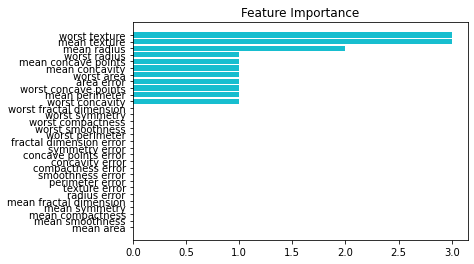

In [70]:

def draw_from_dict(dicdata):
    by_value = sorted(dicdata.items(), key=lambda item: item[1], reverse=False)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
        plt.barh(x, y)
    plt.title('Feature Importance')
    plt.show()

draw_from_dict(dicdata)

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [0]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.RM = self.create_forest(self.n_estimators, self.max_features, self.bootstrap)
        self.prediction = self.predict_label(self.RM, x_test)
        self.accuary = self.evaluation(self.prediction, y_test)
        return None
        # return accuracy
    
    def gini(self, sequence):
        if len(list(sequence)) == 0:
            return 0
        element1 = np.argmax(np.bincount(sequence))
        size = np.shape(sequence)[0]
        result = 1 - ((list(sequence).count(element1)/size)**2 +
          ((size-list(sequence).count(element1))/size)**2)

        return result
    
    def create_forest(self, n_estimators, max_features, bootstrap):
        tree_list = []
        for i in range(n_estimators):
            print('Creating the %d th tree ....' % (i+1))
            if bootstrap == True:
                x_data, y_data = self.getsubsample(x_train, y_train)
                DT = self.create_tree(max_features, x_data, y_data)
            else:
                DT = self.create_tree(max_features, x_train, y_train)
            tree_list.append(DT)
        return tree_list
    # 在dataSet中返回数目最多的类别标记
    
    def majorityClass(self, dataSet):
        labels = list(dataSet.iloc[:, -1])
        element1 = np.argmax(np.bincount(labels))
        return element1
    
    def create_tree(self, max_features, x_data, y_data):
        if len(set(y_data.iloc[:, -1])) == 1:
            return y_data.iloc[0, -1]
        left_child, left_y, right_child, right_y, bestAttribute, bestTh = self.find_threshold(x_data, y_data, max_features)
        decisionTree = {bestAttribute: {}}
        # print(decisionTree)
        decisionTree[bestAttribute][('<=', bestTh)] = self.create_tree(max_features, left_child, left_y)
        decisionTree[bestAttribute][('>', bestTh)] = self.create_tree(max_features, right_child, right_y)
        return decisionTree

    def classify(self, inputTree, testVec):
        firstStr = list(inputTree)[0]
        secondDict = inputTree[firstStr]
        secondStr = list(secondDict)[0]
        TH = secondStr[1]
        attrValue = testVec[firstStr]
        if attrValue <= TH:
            key = ('<=', TH)
        else:
            key = ('>', TH)
        valueOfFeat = secondDict[key]
        if isinstance(valueOfFeat, dict):
            classLabel = self.classify(valueOfFeat, testVec)
        else: classLabel = valueOfFeat
        return classLabel
    
    def getsubsample(self, x_data, y_data):
        x_columns = x_data.columns
        y_columns = y_data.columns
        subdataset_x = pd.DataFrame(columns=x_columns)
        subdataset_y = pd.DataFrame(columns=y_columns)
        len_data = x_data.shape[0]
        while len(subdataset_x) < len_data:
            index = np.random.randint(x_data.shape[0])
            subdataset_x = subdataset_x.append(x_data.iloc[index, :])
            subdataset_y = subdataset_y.append(y_data.iloc[index, :])
        return subdataset_x, subdataset_y
    
    def extract_feature(self,feature, max_feature):
        subset = []
        temp_feature = list(feature)
        while len(subset) < max_feature:
            index = np.random.randint(len(temp_feature))
            subset.append(temp_feature[index])
            del temp_feature[index]
        return subset
    
    def find_threshold(self, x_data, y_data, max_feature):
        best_criterion = 100
        best_attribute = 'bb'
        best_thershold = 0
        feature = list(x_data.columns)
        feature = self.extract_feature(feature, max_feature)
        for _ in feature:
            column = x_data[_]
            sorted_column = np.sort(column)
            for i in range(column.shape[0] - 1):
                average = (sorted_column[i] + sorted_column[i + 1]) / 2
                left = list(np.array(y_data[x_data[_] <= average]).reshape(-1,))
                right = list(np.array(y_data[x_data[_] > average]).reshape(-1,))
                temp_criterion = len(left) / column.shape[0] * self.gini(left) + len(right) / column.shape[0] * self.gini(right)
                if temp_criterion < best_criterion:
                    best_criterion = temp_criterion
                    best_attribute = _
                    best_thershold = average
        left_child = x_data[x_data[best_attribute] <= best_thershold]
        # del left_child[best_attribute]
        left_y = y_data[x_data[best_attribute] <= best_thershold]
        right_child = x_data[x_data[best_attribute] > best_thershold]
        # del right_child[best_attribute]
        right_y = y_data[x_data[best_attribute] > best_thershold]

        return left_child, left_y, right_child, right_y, best_attribute, best_thershold
    
    def predict_label(self, forest, test):
        predict = []
        for i in range(test.shape[0]):
            daixuan = []
            for j in range(self.n_estimators):
                predictLable = self.classify(forest[j], test.iloc[i, :])
                daixuan.append(predictLable)
            element1 = np.argmax(np.bincount(daixuan))
            predict.append(element1)
        return predict
    
    def evaluation(self, predict, y):
        right = 0
        for i in range(len(predict)):
            if predict[i] == int(y.iloc[i]):
                right += 1
        return right / len(predict)


### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [77]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))

Creating the 1 th tree ....
Creating the 2 th tree ....
Creating the 3 th tree ....
Creating the 4 th tree ....
Creating the 5 th tree ....
Creating the 6 th tree ....
Creating the 7 th tree ....
Creating the 8 th tree ....
Creating the 9 th tree ....
Creating the 10 th tree ....


In [78]:
clf_10tree.accuary

0.9440559440559441

In [0]:
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

Creating the 1 th tree ....
Creating the 2 th tree ....
Creating the 3 th tree ....
Creating the 4 th tree ....
Creating the 5 th tree ....
Creating the 6 th tree ....
Creating the 7 th tree ....
Creating the 8 th tree ....
Creating the 9 th tree ....
Creating the 10 th tree ....
Creating the 11 th tree ....
Creating the 12 th tree ....
Creating the 13 th tree ....
Creating the 14 th tree ....
Creating the 15 th tree ....
Creating the 16 th tree ....
Creating the 17 th tree ....
Creating the 18 th tree ....
Creating the 19 th tree ....
Creating the 20 th tree ....
Creating the 21 th tree ....
Creating the 22 th tree ....
Creating the 23 th tree ....
Creating the 24 th tree ....
Creating the 25 th tree ....
Creating the 26 th tree ....
Creating the 27 th tree ....
Creating the 28 th tree ....
Creating the 29 th tree ....
Creating the 30 th tree ....
Creating the 31 th tree ....
Creating the 32 th tree ....
Creating the 33 th tree ....
Creating the 34 th tree ....
Creating the 35 th tree

In [0]:
clf_100tree.accuary

0.9370629370629371

### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [0]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))

Creating the 1 th tree ....
Creating the 2 th tree ....
Creating the 3 th tree ....
Creating the 4 th tree ....
Creating the 5 th tree ....
Creating the 6 th tree ....
Creating the 7 th tree ....
Creating the 8 th tree ....
Creating the 9 th tree ....
Creating the 10 th tree ....


In [0]:
clf_random_features.accuary

0.9440559440559441

In [0]:
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

Creating the 1 th tree ....
Creating the 2 th tree ....
Creating the 3 th tree ....
Creating the 4 th tree ....
Creating the 5 th tree ....
Creating the 6 th tree ....
Creating the 7 th tree ....
Creating the 8 th tree ....
Creating the 9 th tree ....
Creating the 10 th tree ....


In [0]:
clf_all_features.accuary

0.9370629370629371

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 
